**Inteligência Artificial**

**812839 - Vinícius Miranda de Araújo**

**Lista 03**

---
---

### **Questão 1**

---



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Carregar os dados
data = pd.read_csv('titanic.csv')

# Remover colunas irrelevantes ou com muitos valores ausentes
data.drop(columns=['Cabin', 'Ticket', 'Name', 'PassengerId'], inplace=True)

# Preenchendo valores ausentes
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Transformação de dados categóricos
cols_label_encode = ['Sex', 'Embarked']
data[cols_label_encode] = data[cols_label_encode].apply(LabelEncoder().fit_transform)

# Separar variáveis independentes e dependentes
X = data.drop(columns=['Survived'])
y = data['Survived']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Criar modelos com os critérios Gini e Entropy
model_gini = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42)
model_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)

# Treinar os modelos
model_gini.fit(X_train, y_train)
model_entropy.fit(X_train, y_train)

# Fazer previsões
y_pred_gini = model_gini.predict(X_test)
y_pred_entropy = model_entropy.predict(X_test)

# Avaliação do modelo com Gini
print("\n### Árvore com Gini ###")
print("Acurácia:", accuracy_score(y_test, y_pred_gini))
print(classification_report(y_test, y_pred_gini))

# Avaliação do modelo com Entropy
print("\n### Árvore com Entropy ###")
print("Acurácia:", accuracy_score(y_test, y_pred_entropy))
print(classification_report(y_test, y_pred_entropy))

# Matriz de Confusão
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Sobreviveu', 'Sobreviveu'], yticklabels=['Não Sobreviveu', 'Sobreviveu'])
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_gini, "Matriz de Confusão - Gini")
plot_confusion_matrix(y_test, y_pred_entropy, "Matriz de Confusão - Entropy")

# Visualização das árvores
def plot_decision_tree(model, title):
    plt.figure(figsize=(12, 8))
    plot_tree(model, feature_names=X.columns, class_names=['Não Sobreviveu', 'Sobreviveu'], filled=True)
    plt.title(title)
    plt.show()

plot_decision_tree(model_gini, "Árvore de Decisão - Critério Gini")
plot_decision_tree(model_entropy, "Árvore de Decisão - Critério Entropy")

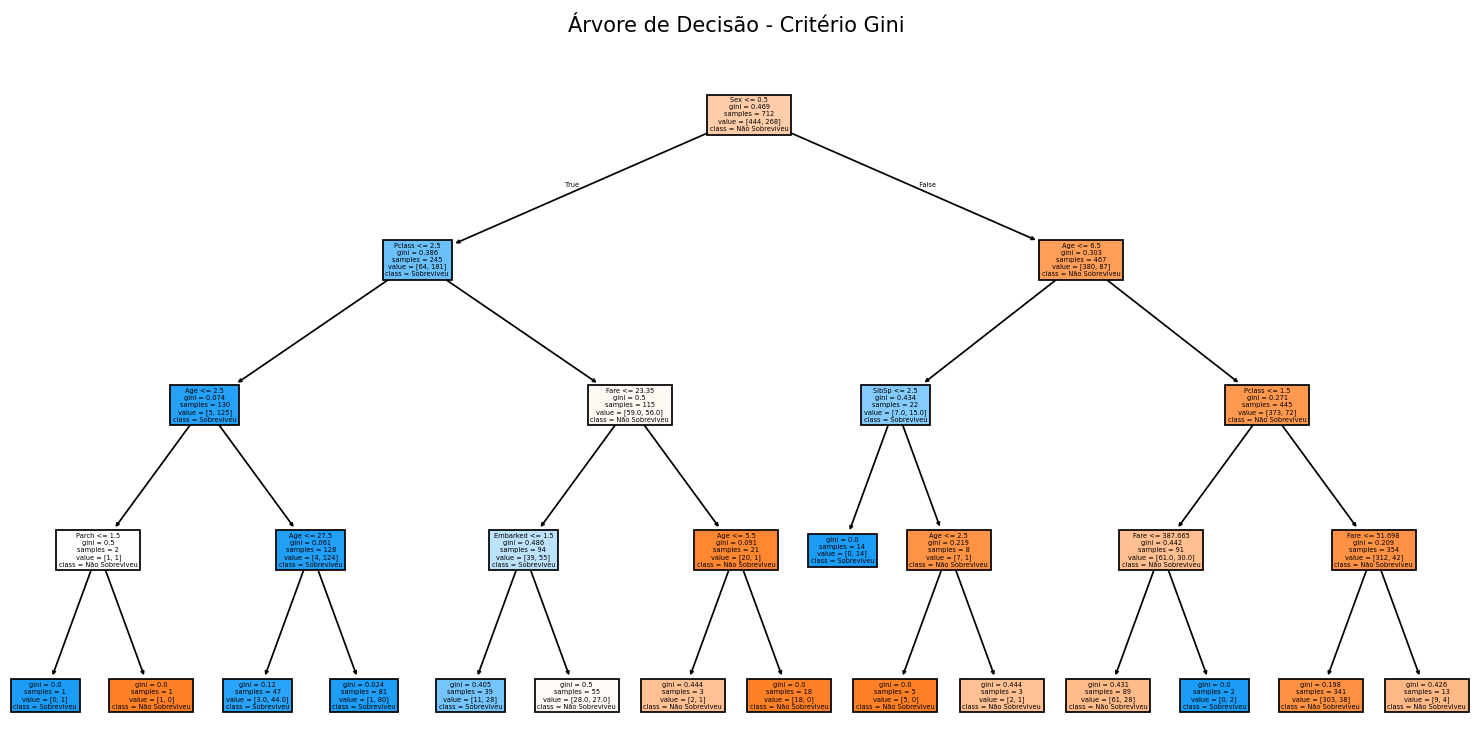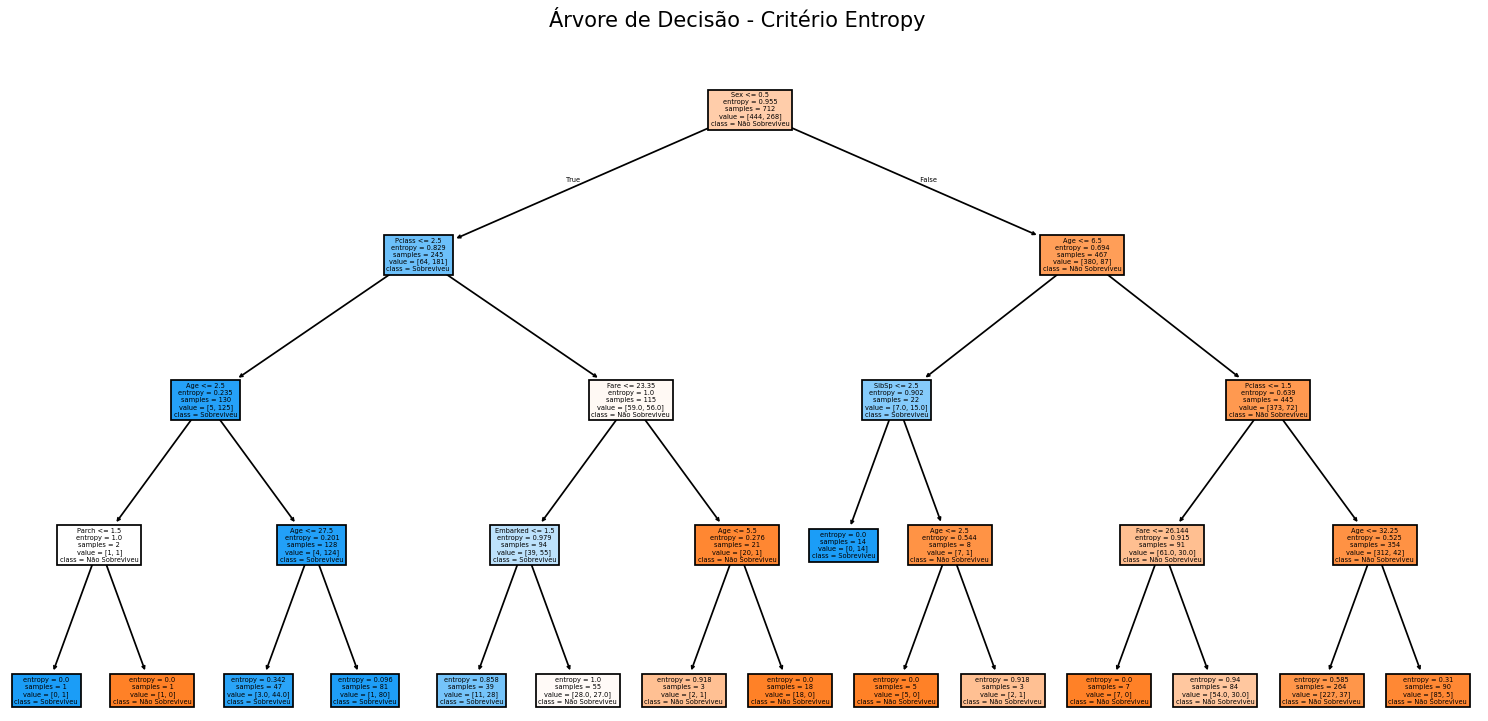

**Explicação dos Critérios Gini e Entropy:**

1. Critério Gini: Mede a impureza de um nó na árvore de decisão. O cálculo é feito com:
   
   Gini = 1 - ∑ pi^2
   
   >pi é a proporção de amostras pertencentes a uma classe no nó.

2. Critério Entropy: Mede a desordem da distribuição das classes em um nó. O cálculo é feito com:
   
   Entropy = - ∑ pi*log(pi, 2)
   
**Comparação:**

- Gini tende a criar divisões mais puras em cada nó.
- Entropy é mais sensível a mudanças pequenas nos dados.
- Em geral, as diferenças entre ambos são pequenas, mas o Gini pode ser ligeiramente mais rápido.

### **Questão 2**

---

A Árvore de Decisão pode ser ajustada através de diversos hiperparâmetros que afetam diretamente sua complexidade e capacidade de generalização.

### 1. `max_depth` (Profundidade Máxima)
- Define a profundidade máxima da árvore.
- Impacto:
  - Muito alta → Overfitting (árvore complexa, aprende ruído dos dados).
  - Muito baixa → Underfitting (modelo muito simples, perde padrões importantes).

### 2. `max_features` (Número Máximo de Atributos por Divisão)
- Define quantos atributos serão considerados na escolha da melhor divisão.
- Valores possíveis:
  - `"sqrt"` → Raiz quadrada do número de atributos.
  - `"log2"` → Logaritmo base 2 do número de atributos.
  - `None` → Usa todos os atributos.
  - Frações (`0.2, 0.4, 0.6, 0.8`) → Usa essa proporção do total de atributos.
- Impacto:
  - Valor alto → Overfitting (pode explorar padrões irrelevantes).
  - Valor baixo → Mais generalização, pode melhorar desempenho.


### 3. `min_samples_split` (Mínimo de Amostras para Divisão)
- Número mínimo de amostras necessário para dividir um nó.
- Impacto:
  - Valor baixo (`2, 5`) → Cria muitas divisões, aumentando a complexidade.
  - Valor alto (`20, 50`) → Garante que cada nó tenha dados suficientes, reduzindo overfitting.


### 4. `min_samples_leaf` (Mínimo de Amostras por Folha)
- Define o número mínimo de amostras que um nó folha pode ter.
- Impacto:
  - Baixo (`1, 5`) → Modelo mais detalhado, mas pode sofrer overfitting.
  - Alto (`10, 20`) → Árvore mais generalizada, melhor para evitar overfitting.


### 5. `criterion` (`gini` vs `entropy`)
- Define a métrica para medir a impureza dos nós.
- Discussão: O `gini` é mais rápido computacionalmente, enquanto `entropy` pode gerar divisões mais informativas.


### 6. `max_leaf_nodes` (Máximo de Nós Folha)
- Limita o número máximo de folhas na árvore.
- Impacto:
  - Menos folhas → Árvore mais simples, generaliza melhor.
  - Mais folhas → Pode sofrer overfitting.


### 7. `class_weight` (Peso das Classes)
- Dá maior peso a classes desbalanceadas.
- Impacto: Se a classe de sobreviventes for minoria, pode ajudar a equilibrar a decisão.

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Definição de hiperparâmetros para GridSearch
params = {
    'criterion':  ['gini', 'entropy'],
    'max_depth':  [None, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20],
}

# Carregar os dados
data = pd.read_csv('titanic.csv')

# Remover colunas irrelevantes ou com muitos valores ausentes
data.drop(columns=['Cabin', 'Ticket', 'Name', 'PassengerId'], inplace=True)

# Preenchendo valores ausentes
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Transformação de dados categóricos
cols_label_encode = ['Sex', 'Embarked']
data[cols_label_encode] = data[cols_label_encode].apply(LabelEncoder().fit_transform)

# Separar variáveis independentes e dependentes
X = data.drop(columns=['Survived'])
y = data['Survived']

# Dividir os dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=42)

# GridSearchCV para otimização
modelo = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    cv=10,
    n_jobs=-1,
    verbose=1,
)

modelo.fit(X_treino, y_treino)
print("Melhores hiperparâmetros:", modelo.best_params_)
print("Melhor pontuação:", modelo.best_score_)

### **Questão 3**

---

1. **GridSearchCV:** Faz uma busca exaustiva testando todas as combinações
possíveis dos hiperparâmetros especificados. Garante encontrar a melhor configuração, mas pode ser computacionalmente caro.

2. **RandomizedSearchCV:** Amostra aleatoriamente um subconjunto de combinações possíveis, reduzindo o custo computacional, mas sem a garantia de encontrar a melhor configuração absoluta.

3. **BayesSearchCV:** Utiliza otimização Bayesiana para escolher inteligentemente os hiperparâmetros a serem testados com base nos resultados anteriores, balanceando precisão e eficiência.

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV

# Carregar os dados
data = pd.read_csv("titanic.csv")

# Remover colunas irrelevantes
data.drop(columns=['Cabin', 'Ticket', 'Name', 'PassengerId'], inplace=True)

# Preenchendo valores ausentes
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Transformação de dados categóricos
cols_label_encode = ['Sex', 'Embarked']
data[cols_label_encode] = data[cols_label_encode].apply(LabelEncoder().fit_transform)

# Separar variáveis independentes e dependentes
X = data.drop(columns=['Survived'])
y = data['Survived']

# Dividir os dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.20, random_state=42)

# Definir hiperparâmetros
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# GridSearchCV
grid_search = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_treino, y_treino)

print("Melhores parâmetros (GridSearchCV):", grid_search.best_params_)
print("Acurácia (GridSearchCV):", grid_search.best_score_)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=params,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
random_search.fit(X_treino, y_treino)

print("Melhores parâmetros (RandomizedSearchCV):", random_search.best_params_)
print("Acurácia (RandomizedSearchCV):", random_search.best_score_)

# BayesSearchCV
bayes_search = BayesSearchCV(
    DecisionTreeClassifier(),
    search_spaces=params,
    cv=5,
    n_iter=10,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
bayes_search.fit(X_treino, y_treino)

print("Melhores parâmetros (BayesSearchCV):", bayes_search.best_params_)
print("Acurácia (BayesSearchCV):", bayes_search.best_score_)

### **Questão 4**

---

Considere um modelo de classificação binária que identifica fraudes em transações financeiras. Suponha que a base de dados tenha um número significativamente maior de transações legítimas do que fraudulentas. Com base nas métricas de avaliação precisão (precision), revocação (recall) e F1-score, analise as seguintes afirmações:

**I.** Se o modelo tem alta precisão, isso significa que a maioria das transações classificadas como fraudulentas realmente são fraudes, mas pode estar deixando muitas fraudes reais passarem despercebidas.

**II.** Se o modelo tem alta revocação, isso significa que ele consegue identificar quase todas as fraudes, mas pode incluir muitas transações legítimas como fraudulentas.

**III.** O F1-score é útil quando há um grande desequilíbrio entre classes, pois equilibra precisão e revocação, sendo sempre a média aritmética dessas métricas.

Qual das alternativas abaixo é correta?

A) Apenas I e II

B) Apenas II e III

C) Apenas I e III

D) I, II e III

>**Resposta: Letra A**

### **Questão 5**

---

Um modelo de diagnóstico de doenças raras foi desenvolvido para identificar pacientes infectados com uma condição grave. Com base nas métricas precisão (precision) e revocação (recall), analise as seguintes afirmações:

**I.** Se a revocação for aumentada, mais casos reais da doença serão detectados, mas isso pode aumentar os falsos positivos, reduzindo a precisão.

**II.** Se um modelo tem alta precisão, isso significa que a maioria dos pacientes diagnosticados como positivos realmente tem a doença, mas isso não garante que todos os doentes tenham sido identificados.

**III.** Para um diagnóstico de doenças altamente letais, um modelo com alta precisão sempre é preferível a um modelo com alta revocação, pois evita alarmes falsos e diagnósticos errados.

Qual das alternativas abaixo é correta?

A) Apenas I e II

B) Apenas I e III

C) Apenas II e III

D) I, II e III

>**Resposta: Letra A**

### **Questão 6**

---

**ID3**

- Utiliza exclusivamente a entropia e o ganho de informação para escolher os atributos que farão a separação dos dados.
- Ignora exemplos que contêm valores ausentes, o que pode reduzir a quantidade de dados disponíveis para a aprendizagem.
- Só funciona com atributos categóricos.
- Não realiza poda após a construção da árvore, o que pode gerar sobreajuste aos dados de treinamento.
- Pode gerar árvores com múltiplos ramos por nó (se um atributo tiver 10 valores, pode gerar 10 ramos).


**C4.5**

- Introduz o ganho de informação normalizado (ou razão de ganho), que reduz o viés do ID3 em favorecer atributos com muitos valores distintos.
- Permite valores ausentes ao calcular probabilidades para cada possível valor de um atributo ausente.
- Suporta atributos contínuos, determinando automaticamente pontos de corte para dividir os valores numéricos em faixas.
- Aplica poda pós-poda (post-pruning) para reduzir o tamanho da árvore e melhorar a generalização.
- Embora suporte múltiplos ramos, pode converter a árvore em um formato binário para simplificar sua estrutura.

>**Resumo**
>
>| Característica          | ID3                 | C4.5                       |
>|-------------------------|---------------------|----------------------------|
>| **Critério de Escolha** | Ganho de Informação | Razão de Ganho             |
>| **Atributos Numéricos** | Não suporta         | Suporta e define pontos de corte  |
>| **Valores Ausentes**    | Ignora os exemplos  | Trabalha com probabilidades |
>| **Poda**                | Não realiza         | Aplica poda pós-construção  |
>| **Estrutura da Árvore** | Multifurcada        | Pode converter em binária   |



### **Questão 7**

---

A principal diferença entre as duas métricas é que o ganho de informação favorece atributos com muitos valores, enquanto a razão de ganho normaliza essa métrica, penalizando divisões complexas, e é, portanto, mais equilibrada na escolha dos atributos.